# Day 1, Part 4: Gravity experiement
Taking from: https://nbviewer.jupyter.org/github/engineersCode/EngComp3_tourdynamics/blob/master/notebooks_en/1_Catch_Motion.ipynb

BSD 3-Clause License

Copyright (c) 2018, engineersCode
All rights reserved.

In [1]:
%matplotlib notebook
# NOTE: you might have to restart the kernel

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# a library to do some image manipulation
import imageio

With the ```get_reader()``` method of ```imageio```, you can read a video from its source into a Reader object. You don't need to worry too much about the technicalities here—we'll walk you through it all—but check the type, the length (for a video, that's number of frames), and notice you can get info, like the frames-per-second, using ```get_meta_data()```.

In [4]:
# note, you may get the following error:
#ImportError: To use the imageio ffmpeg plugin you need to 'pip install imageio-ffmpeg'
# so then, do what they say!

!pip install imageio-ffmpeg
# note the "!" is an escape character we need to get it to work

reader = imageio.get_reader('https://d3tsb3m56iwvoq.cloudfront.net/transcoded/techtv/a054739f22d04659b13f05e44879952a/hd.mp4')

While we won't use these features explicitly, its worth noting you can use this library to do interesting things like figure out the frames per second:

In [5]:
fps = reader.get_meta_data()['fps']
print(fps)

29.97


Note:

You may get this error after calling get_reader():

NeedDownloadError: Need ffmpeg exe. You can obtain it with either:

install using conda: 

conda install ffmpeg -c conda-forge

download by calling: imageio.plugins.ffmpeg.download()

If you do, follow the tips to install the needed ffmpeg tool.

Now we can use the ```get_data()``` method on the ```imageio Reader``` object, to grab one of the video frames, passing the frame number. Below, we use it to grab frame number 1100, and then print the shape attribute to see that it's an "array-like" object with three dimensions: they are the pixel numbers in the horizontal and vertical directions, and the number of colors (3 colors in RGB format). 

In [6]:
image = reader.get_data(1100)
image.shape
# y-pixels, x-pixels, # of colors (RGB)

(1080, 1440, 3)

We chose to show frame 1100 after playing around a bit and finding that it gives a good view of the long-exposure image of the falling ball.

<IPython.core.display.Javascript object>


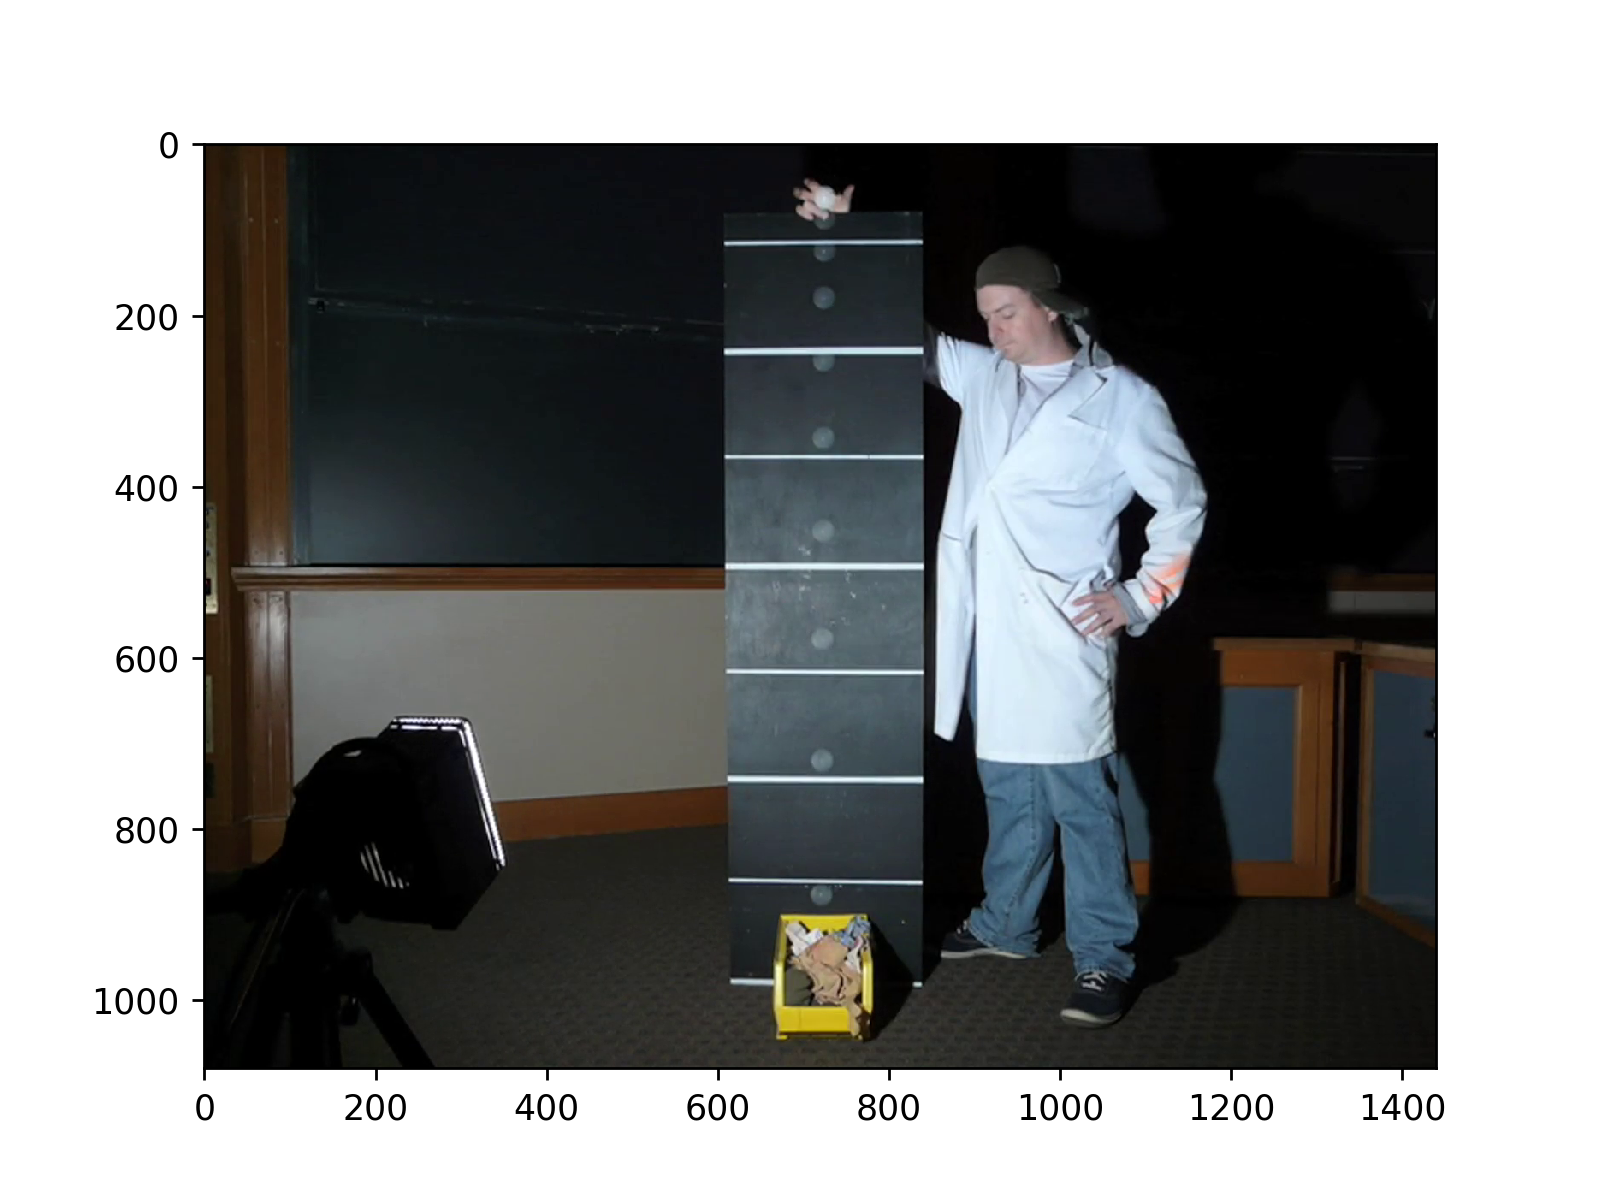

In [7]:
plt.imshow(image, interpolation='nearest');



### Explore:

Check out the neat interactive options that we get with ```%matplotlib notebook```. Then go back and change the frame number above, and show it below. Notice that you can see the (x,y) coordinates of your cursor tip while you hover on the image with the mouse.

Okay! Here is where things get really interesting. Matplotlib has the ability to create event connections, that is, connect the figure canvas to user-interface events on it, like mouse clicks.

We'll play more with interactive plotting next week, but for now we'll just use a few functions that allow us to interact with the plot to measure the acceleration of gravity.

To use this ability, you write a function with the events you want to capture, and then connect this function to the Matplotlib "event manager" using ```mpl_connect()```. In this case, we connect the ```'button_press_event'``` to the function named ```onclick()```, which captures the (x,y) coordinates of the mouse click on the figure. Magic!

<IPython.core.display.Javascript object>


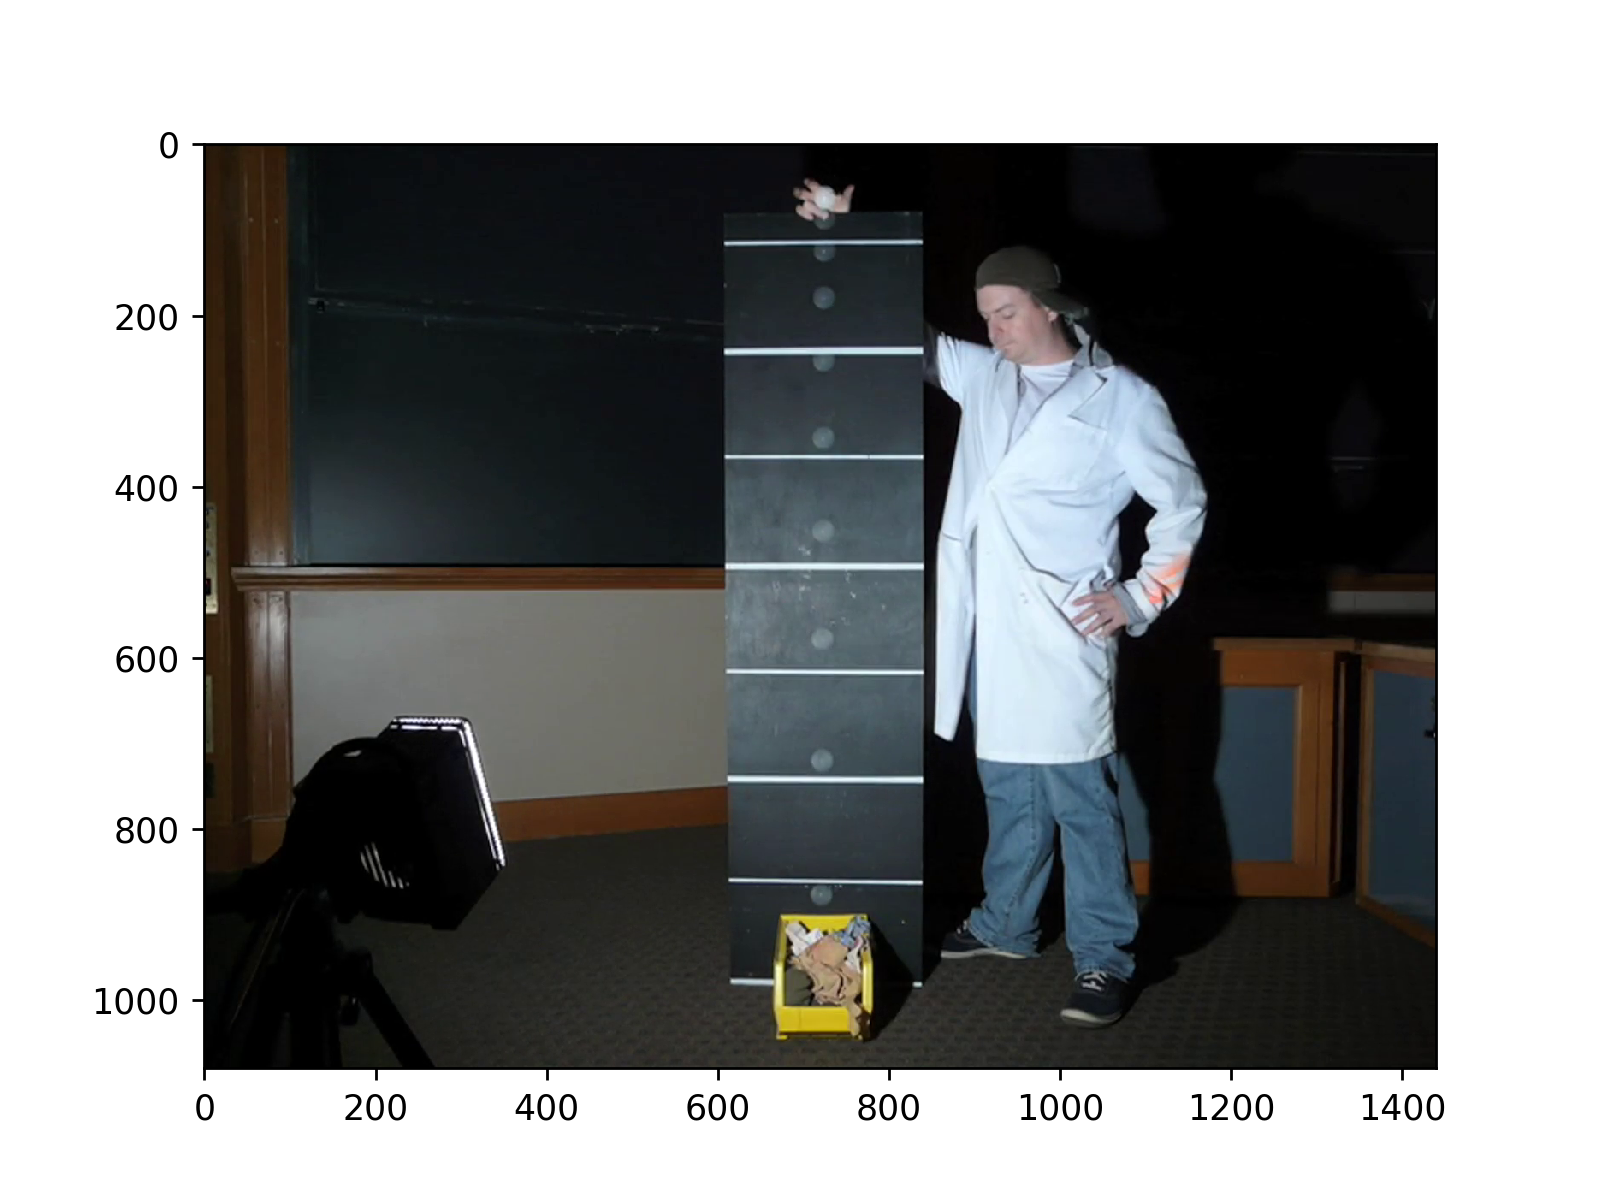

In [21]:
# make a figure much like we did before
# make an explicit "fig" object to 
# connect mouse clicks to later
fig = plt.figure()

# show the image like before
plt.imshow(image, interpolation='nearest')

# empty - will be filled with clicked coords
coords = [] 

# the onclick function will do stuff when we click on the figure
def onclick(event): # "event" is the click
    '''Capture the x,y coordinates of a mouse click on the image'''
    # event is special - it holds something called xdata & ydata
    #  that you can access with event.xdata & event.ydata
    #  here the "." can be thought of as an "trait" associated 
    #  with the event "object"
    x, y = event.xdata, event.ydata
    # update or list with these clicks
    coords.append([x, y]) 

# finally, attach our function "onclick" to a "known event" 
#  in matplotlib - clicking on a figure
# connectId allows us to disconnect later
connectId = fig.canvas.mpl_connect('button_press_event', onclick)



Notice that in the previous code cell, we created an empty list named ```coords```, and inside the ```onclick()``` function, we are appending to it the (x,y) coordinates of each mouse click on the figure. After executing the cell above, you have a connection to the figure, via the user interface: try clicking with your mouse on the **endpoints of the white lines** of the metered panel (click on the edge of the panel to get approximately equal x coordinates), then print the contents of the ```coords``` list below, after we "disconnect" from this figure with:

In [22]:
fig.canvas.mpl_disconnect(connectId)


In [23]:
coords

[[782.7994862345906, 116.49268588772065],
 [794.4877979229022, 239.2199586149934],
 [782.7994862345906, 364.869309264344],
 [788.6436420787466, 496.3628157578505],
 [785.7215641566686, 619.0900884851233],
 [788.6436420787466, 744.7394391344739],
 [785.7215641566686, 861.6225560175908],
 [797.4098758449802, 987.2719066669414]]

The x coordinates are pretty close, but there is some variation due to our shaky hand (or bad eyesight), and perhaps because the metered panel is not perfectly vertical. 

Now, let's grab all the second elements of the coordinate pairs, corresponding to the y coordinates, i.e., the vertical positions of the white lines on the video frame.

In [24]:
y_lines = np.array(coords)[:,1]
y_lines

array([116.49268589, 239.21995861, 364.86930926, 496.36281576,
       619.09008849, 744.73943913, 861.62255602, 987.27190667])

The above are the **pixel** coordinates of the **white** lines - but for measuring the acceleration due to gravity, we would like the coordinates in **meters from the ground** of the **ball**.  To do that, we'll need to convert.  From the video we know the white lines are every 1/4 meters so we can use them to calculate a pixel-to-meters conversion factor:

In [25]:
# now, notice that the y-pixels go from zero at the 
#  top of the image to 1040 at the bottom, so we 
# want to first invert this with:

#y_lines = image.shape[0] - y_lines
# this uses the y-lenght of the image from before
#y_lines

# now, lets subtract the lowest pixel as this is the ground
#y_lines -= y_lines[-1]
# the above is a short hand for "subtract the last element from all"
#y_lines

# finally, lets convert from pixels to meters
# since we know there are white lines every 1/4
#  meter, we can get the *average* conversion factor
dy = np.roll(y_lines,-1) - y_lines
dy # change in pixels

# use all by the last one:
pixels_to_meters = 0.25/dy[:-1].mean()
# 1/4 meters, and then the last part says mean over all but last element
print('conversion factor: meters/pixel = ', pixels_to_meters)
# so there about 0.002 meters per pixel

conversion factor: meters/pixel =  0.002009694258016406


## Exercise

Let's now redo the whole thing, but collect the points of the ball.

Notice that the coordinates will not be uniform this time!

## Possible Answer:

<IPython.core.display.Javascript object>


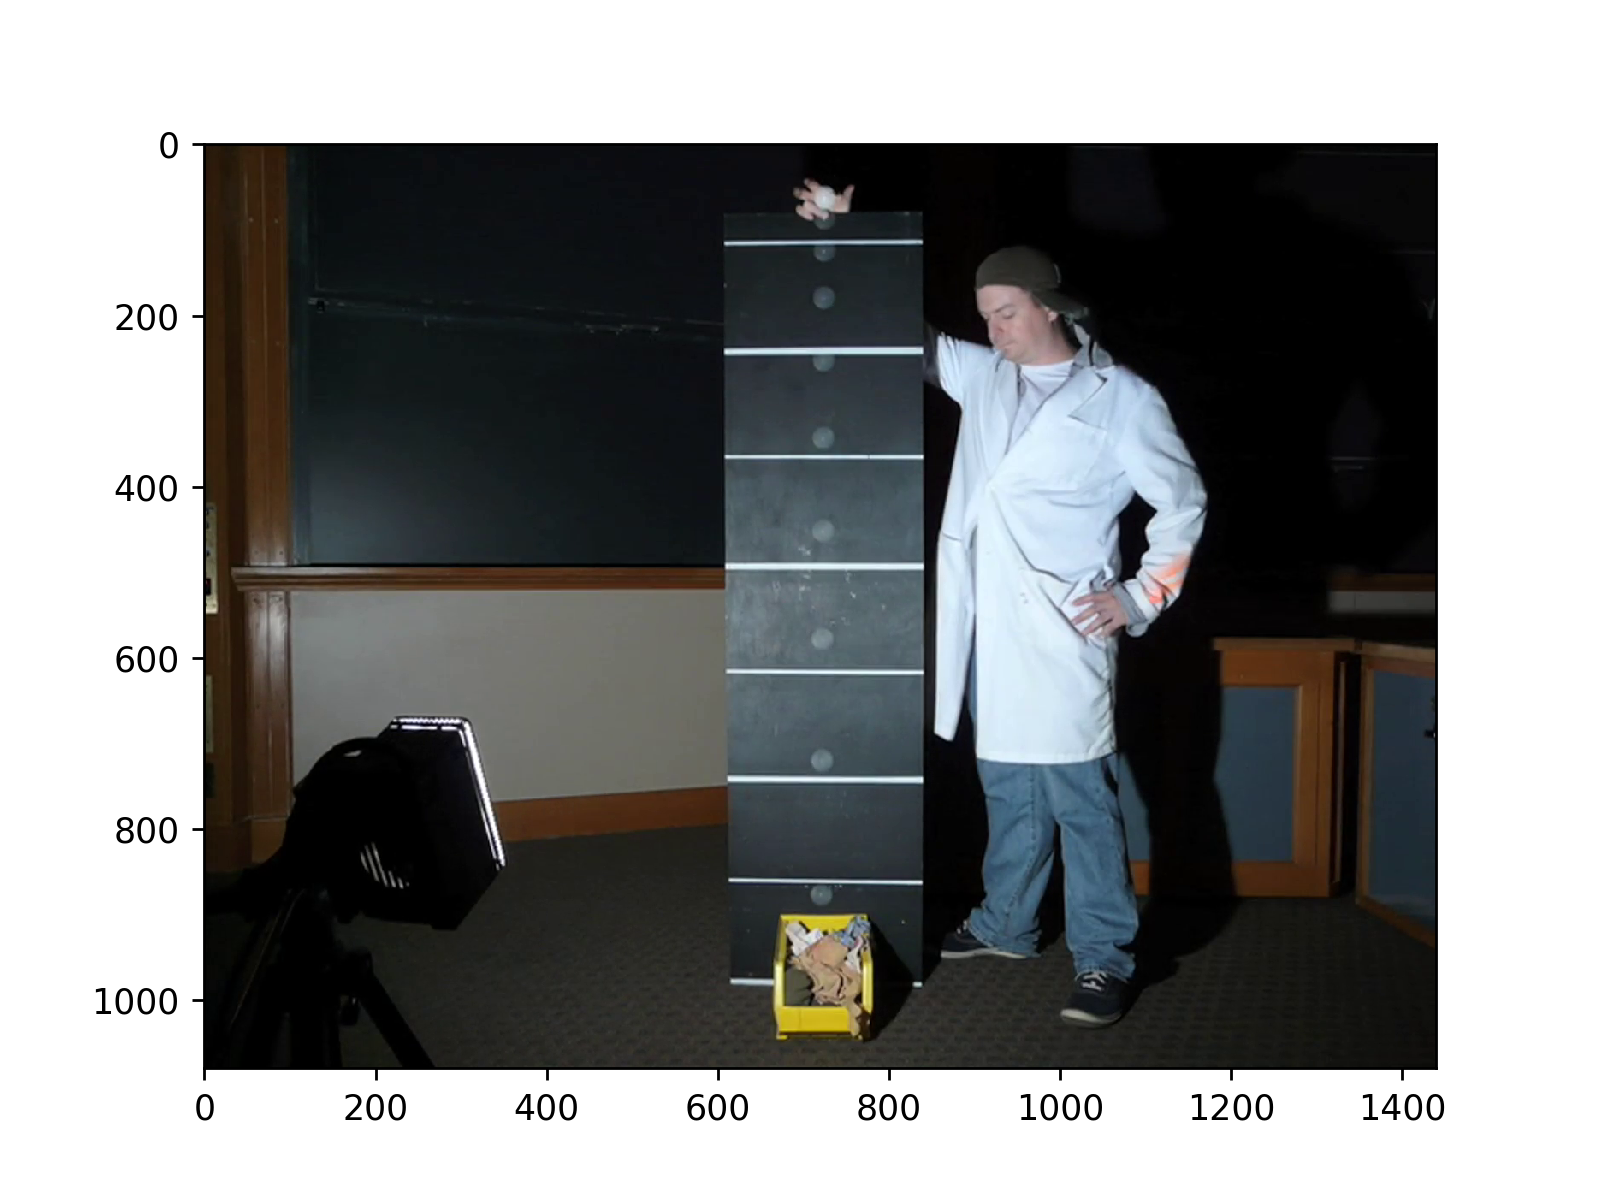

In [26]:
# make a figure much like we did before
# make an explicit "fig" object to 
# connect mouse clicks to later
fig = plt.figure()

# show the image like before
plt.imshow(image, interpolation='nearest')

# empty - will be filled with clicked coords
coords_ball = [] 

# the onclick function will do stuff when we click on the figure
def onclick(event): # "event" is the click
    '''Capture the x,y coordinates of a mouse click on the image'''
    # event is special - it holds something called xdata & ydata
    #  that you can access with event.xdata & event.ydata
    #  here the "." can be thought of as an "trait" associated 
    #  with the event "object"
    x, y = event.xdata, event.ydata
    # update or list with these clicks
    coords_ball.append([x, y]) 

# finally, attach our function "onclick" to a "known event" 
#  in matplotlib - clicking on a figure
# connectId allows us to disconnect later
connectId = fig.canvas.mpl_connect('button_press_event', onclick)



In [27]:
fig.canvas.mpl_disconnect(connectId)

coords_ball

[[724.3579277930322, 62.215097402597394],
 [721.4358498709543, 91.43587662337654],
 [724.3579277930322, 126.50081168831161],
 [724.3579277930322, 184.94237012987014],
 [724.3579277930322, 255.07224025974028],
 [718.5137719488764, 345.6566558441558],
 [718.5137719488764, 459.6176948051948],
 [718.5137719488764, 579.4228896103896],
 [718.5137719488764, 725.5267857142857],
 [718.5137719488764, 886.2410714285713]]

## Compute the acceleration of gravity

Using the vertical displacements of the ball, lets call these $\Delta y_i$, and the known time between two flashes of the strobe light, $\Delta t_i = \Delta t = 1/16.8s$, you can get the velocity and acceleration of the ball! Then you can convert these into meters using our ```pixels_to_meters``` conversion factor we used before.



Let's find the velocities using **Eulers Method**:

$v_{i} = \frac{\Delta y_i}{\Delta t} = \frac{y_{i+1} - y_{i}}{\Delta t} $

In [28]:
# first calculate the top part: delta_y
y_ball = np.array(coords_ball)[:,1]

delta_y = (y_ball[1:] - y_ball[:-1]) * pixels_to_meters
delta_y

# using Delta t = 1/16.8 s => calculate velocity
v_ball = delta_y/(1.0/16.8)
v_ball

array([0.98657718, 1.18389262, 1.97315436, 2.36778523, 3.05838926,
       3.84765101, 4.04496644, 4.93288591, 5.4261745 ])

So we can see that the velocity is increasing as the ball goes downwards.  Notice here we didn't have to bother with the actual y-coordinate values => just their deltas

## Exercise
Use Euler's method to figure out the acceleration.

Hint: what are the units of velocity above in ```v_ball```?  What are units of acceleration?

## Possible Answer

Like with velocity we know:

$a_i = \frac{\Delta v_i}{\Delta t} = \frac{v_{i+1} - v_i}{\Delta t}$

In [29]:
delta_v = (v_ball[1:] - v_ball[:-1]) # no conversion factor

a_ball = delta_v/(1.0/16.8)

a_ball

array([ 3.31489933, 13.25959732,  6.62979866, 11.60214765, 13.25959732,
        3.31489933, 14.91704698,  8.28724832])

So, the above has a lot of variation, but what is the mean? How big is this variation?

In [30]:
a_ball.mean(), a_ball.std()

(9.32315436241611, 4.301193651804467)

So, while the SD is pretty large (3 m/$s^2$!), the average we get of $\sim 9.5 m/s^2$ is actually pretty close to the actual value of $9.8 m/s^2$!  That is pretty good for us!

Note there are many other factors at play here like the fact that this is not a ball dropping in a vaccum - its a ball dropping with air resistence which slows it down.

# Gravity + Circular motion = orbital motion

We can put this together with our ideas of uniform circular motion to calculate some simplistic orbits.

For right now, assume orbits are **uniform** i.e. a single, constant $\omega$.

### Exercise #1:
If I throw a ball parallel to the Earth's surface, what velocity is required to have the ball orbit the Earth?

Recall: $a_c = \frac{v^2}{r}$ and we've just calculated the acceleration due to gravity as $a_c = g = 9.8 m/s^3$

### Ans #1:

In [34]:
#vorb = sqrt(r*g)
# r = rE = 6.37E6 meters

vorb = np.sqrt(6.378e6 * 9.8) # in m/s
vorb/1e3 # km/s

7.90597242595748

### Exercise #2:
What is the orbital period of this object?

### Ans #2:

In [36]:
T = 6.37e6*2*np.pi/vorb
T # in sec

# or
T/60 # in min

84.37479973014776

You can also use vorb to calculate $\omega$ and then get it from there.